In [343]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [344]:
# Inlezen van CSV-bestand
dataPositions = pd.read_csv('../data-train-sin/positions_xyz_128px_2024-03-05_full.csv')
dataCoordinates = pd.read_csv('../data-train-sin/red_ball_coordinates_128px_2024-03-05_full.csv')
dataPositions.shape, dataCoordinates.shape

((10543, 3), (10543, 14))

In [345]:
combined = pd.concat([dataCoordinates, dataPositions], axis=1)
# remove the rows with to more than 3 NaN values
combined = combined.dropna()
combined = combined

In [346]:
X = combined.iloc[:, :14] # select all rows and columns from 0 to 13
y = combined.iloc[:, 14:] # select x y z output columns

### Data Preprocessing

### Splitting the dataset into the Training set and Test set

In [347]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Splitting the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.01, random_state=42)


In [348]:
y_train.shape, y_val.shape, y_test.shape

((10158, 3), (103, 3), (104, 3))

In [349]:
X_train.isna().sum()

u0    0
v0    0
u1    0
v1    0
u2    0
v2    0
u3    0
v3    0
u4    0
v4    0
u5    0
v5    0
u6    0
v6    0
dtype: int64

In [350]:
y_train.isna().sum()

x    0
y    0
z    0
dtype: int64

In [351]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

X_train_scaled.shape[0], X_val_scaled.shape[0], X_test_scaled.shape[0]

(10158, 103, 104)

In [352]:
# show all the NaN values in the dataset
X_train_scaled

array([[-0.92935387,  0.99021898, -0.56180545, ..., -0.06407004,
        -0.84369072,  0.24917027],
       [-0.05432281, -1.55130082, -1.33986187, ...,  0.4300483 ,
        -0.19013146,  0.96507325],
       [-1.29508951,  0.1681265 , -0.38477818, ..., -0.98680732,
        -1.17734992, -0.7822952 ],
       ...,
       [-0.85339631, -0.39944243, -0.53733826, ...,  1.92044712,
         1.33484014,  0.30882885],
       [ 1.69300485, -0.92260908,  1.66470821, ...,  1.2589414 ,
         2.85981174, -0.88434278],
       [-1.28939269, -0.39572676, -2.52407353, ...,  1.60890246,
        -1.32296751,  2.7548307 ]])

### Hyperparameter tuning

In [353]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor

# Define a parameter grid for the MLPRegressor
param_grid = {
    'model__hidden_layer_sizes': [(100,), (150,), (200,)],
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [10000, 20000, 28000],
    'model__early_stopping': [True],
}

# Create a pipeline with an MLPRegressor model
pipeline = Pipeline([
    ('model', MLPRegressor(random_state=42))
])
model = MLPRegressor(hidden_layer_sizes=(200,), solver='adam', max_iter=10000, early_stopping=True, random_state=42, activation='logistic', learning_rate='constant', learning_rate_init=0.1)
# Perform a randomized search over the parameter grid
#{'model__solver': 'adam', 'model__max_iter': 10000, 'model__learning_rate_init': 0.01, 'model__learning_rate': 'constant', 'model__hidden_layer_sizes': (200,), 'model__early_stopping': True, 'model__activation': 'logistic'}
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

#### Train the model

In [354]:
model.fit(X_train_scaled, y_train_scaled)

MLPRegressor(activation='logistic', early_stopping=True,
             hidden_layer_sizes=(200,), learning_rate_init=0.1, max_iter=10000,
             random_state=42)

#### Result of the hyperparameter tuning

In [355]:
#model = random_search.best_estimator_

In [356]:
#print('fBest parameters found:\n', random_search.best_params_)

#### Make Predictions

In [357]:
y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

#### Evaluate the model

In [358]:
from utils.evaluate import evaluate_model

mse_val, mae_val, r2_val = evaluate_model(y_val, y_val_pred, "Validation")

Mean Squared Error on Validation Set: 0.3126741007155334
Mean Absolute Error on Validation Set: 0.35300431606565336
R2 Score on Validation set: 0.9258986363043183


In [359]:
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

In [370]:
mse_test, mae_test, r2_test = evaluate_model(y_test, y_test_pred, "Test")

Mean Squared Error on Test Set: 0.4098845655758134
Mean Absolute Error on Test Set: 0.36252056238192826
R2 Score on Test set: 0.9122956269272372


#### Visualize the results
The test data is randomized so the plot won't show a clean trajectory

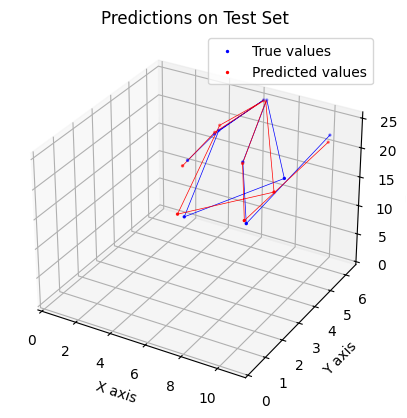

In [371]:
from utils.plot_maker_gaussian_process import plot_maker_3d

plot_maker_3d(np.array(y_test)[:10], np.array(y_test_pred)[:10], "Predictions on Test Set")

# Make Predictions on new data

In [362]:
test_data = pd.read_csv('../data-test-sin/red_ball_coordinates_2024-03-05_12h01m.csv', delimiter=',', decimal='.')
test_result = pd.read_csv('../data-test-sin/positions_xyz_2024-03-05_12h01m.csv', delimiter=',', decimal='.')

In [363]:
new_combined = pd.concat([test_data, test_result], axis=1)
new_combined = new_combined.dropna()
new_combined = new_combined

In [364]:
new_X = new_combined.iloc[:, :14]
new_y = new_combined.iloc[:, 14:]
new_X.shape, new_y.shape

((1358, 14), (1358, 3))

In [365]:
new_X_scaled = scaler_X.fit_transform(new_X)
new_y_scaled = scaler_y.fit_transform(new_y)

In [366]:
new_y_pred_scaled = model.predict(new_X_scaled)

In [367]:
new_y_pred = scaler_y.inverse_transform(new_y_pred_scaled)

In [368]:
new_mse, new_mae, new_r2 = evaluate_model(new_y, new_y_pred, "New Data")

Mean Squared Error on New Data Set: 6.341157785129035
Mean Absolute Error on New Data Set: 1.7333138093809823
R2 Score on New Data set: -0.46521753405043437


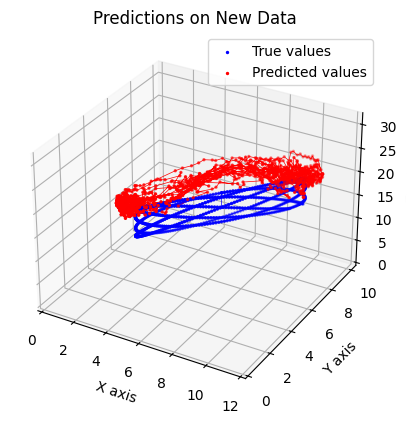

In [369]:
plot_maker_3d(np.array(new_y), np.array(new_y_pred), "Predictions on New Data")